In [1]:
using Pkg, PerlaTonettiWaugh, Plots
pkg"activate ."

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184


# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [2]:
# Define common objects. 
params = parameter_defaults()
settings = settings_defaults()
d_0 = params.d_0
d_T = params.d_T
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T
z_grid = settings.z
M = length(z_grid)

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

## Welfare in steady states

### Steady state at `T`

In [3]:
display_stationary_sol(stationary_sol);

g = 0.02061571025451869
z_hat = 1.4039337089833719
Ω = 1.2562899021346912
π_bar_agg = 0.24067321697108107
y = 1.3124933029733836
c = 1.3124933029733836
λ_ii = 0.7552342507009538
U_bar(0.0) = 65.13570628500445
L_tilde = 0.20995404933168824
z_bar = 1.6612872983693239
w = 0.4164044762305304
x = 1.0
π_min = 0.057942557184611596
r = 0.09361571025451869
a = 9.160936798572518
b = 0.1424454937862814
S = 0.03389742155326495


### Steady state at `0`

In [4]:
display_stationary_sol(stationary_sol_0);

g = 0.010930652401731534
z_hat = 1.8135361316618857
Ω = 1.7797900066500179
π_bar_agg = 0.25994344518684737
y = 1.4215794016174819
c = 1.4215794016174819
λ_ii = 0.8982453618576186
U_bar(0.0) = 44.91505641315042
L_tilde = 0.19292029504963126
z_bar = 1.761386629967237
w = 0.44149454330440074
x = 1.0
π_min = 0.04969310649090876
r = 0.08393065240173153
a = 12.46809835198446
b = 0.14906085711322886
S = -0.011680460701951403


# Transition dynamics

Setup for optimizer:

In [5]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0));

Find the corresponding solution:

In [6]:
result = solve_full_model_global(settings);
solved = result.solution;
E_nodes = result.E_nodes;

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.35 secs, 2 evals, 1 steps, fitness=0.035782269
2.12 secs, 4 evals, 2 steps, fitness=0.035782269

Optimization stopped after 3 steps and 2.8510000705718994 seconds
Termination reason: Max number of steps (2) reached
Steps per second = 1.0522623380357237
Function evals per second = 2.1045246760714473
Improvements/step = 0.0
Total function evaluations = 6


Best candidate found: [-0.928323, -0.793123, -0.604936, -0.492704, -0.335835, -0.249741, -0.24268, -0.125186, -0.0948087, -0.0877639, -0.0573027, -0.0451288, -0.0307141, -0.0301002]

Fitness: 0.035782269



In [7]:
println("E_nodes (sorted) : ")
sort(E_nodes)

E_nodes (sorted) : 


14-element Array{Float64,1}:
 -0.9283233397558605  
 -0.7931227777335486  
 -0.6049356364806617  
 -0.4927044449099116  
 -0.3358353090972862  
 -0.2497406170581776  
 -0.24267972513426644 
 -0.1251863870906156  
 -0.0948087489326721  
 -0.08776386898955374 
 -0.05730272455803215 
 -0.04512884607138278 
 -0.030714141187059757
 -0.03010019595942575 

## Plots for Ω and `entry_residuals`

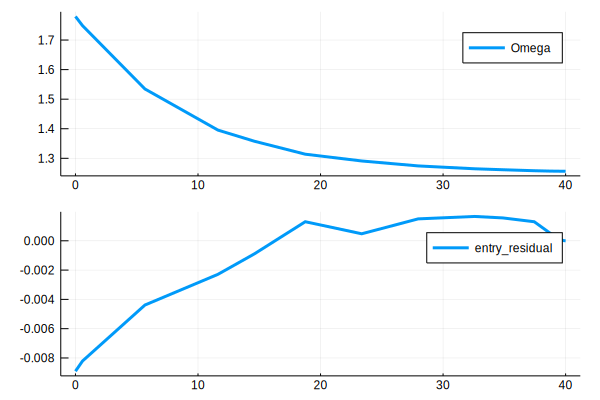

In [8]:
solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

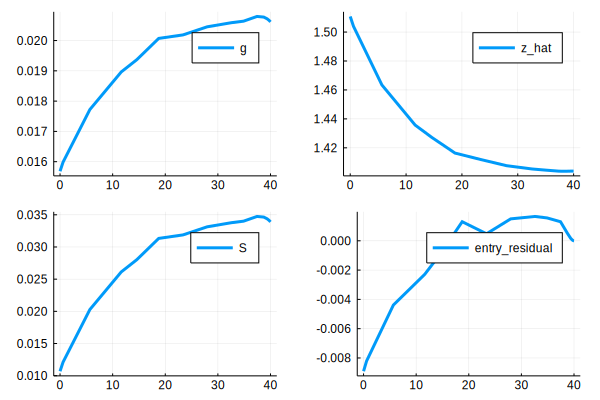

In [9]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

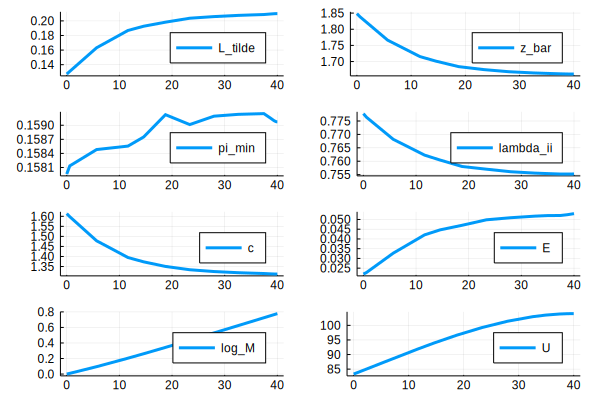

In [10]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

# Welfare analysis

### `log_M(t)`

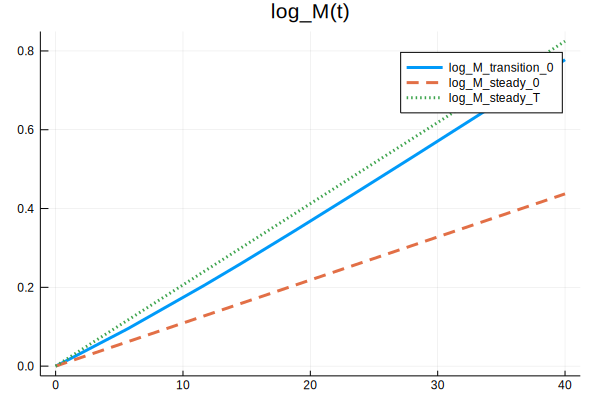

In [11]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

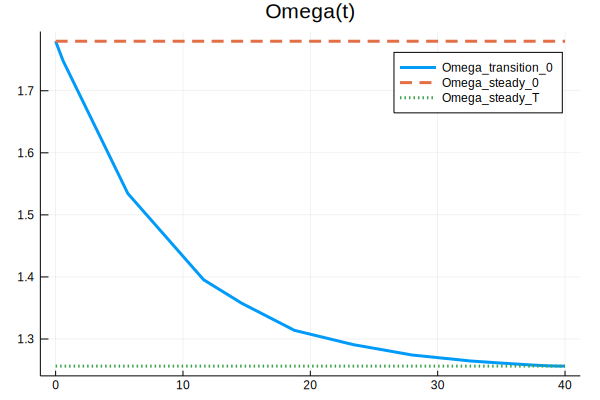

In [12]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

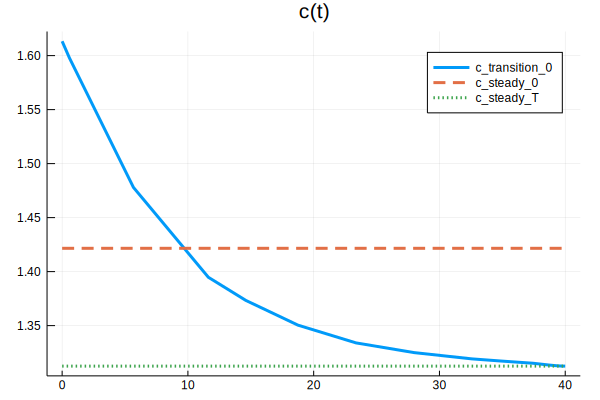

In [13]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

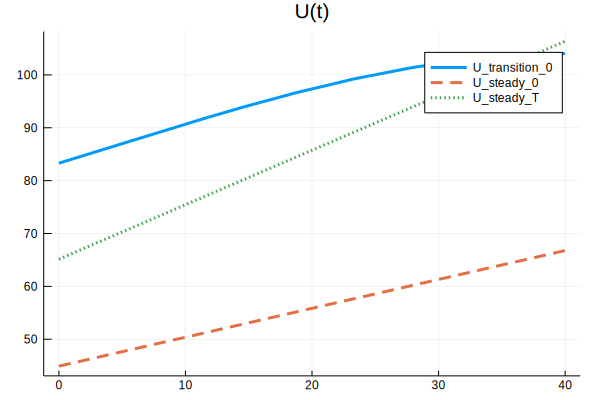

In [14]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [15]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), params)

2.106198939605612

### `M(0)` by autarky and transition from `t=0`

In [16]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), params)

1.391878168224176